In [611]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

# pip install python-dotenv

load_dotenv()
file_path = os.getenv("FILE_PATH")
file_path

'/Users/benjaminang/prac2025/stats-practitioner-challenge/challenge'

In [612]:
SNP_prices_file = f'{file_path}/S&P 500 Index.csv'
SNP_VIX_file = f'{file_path}/S&P 500 VIX.csv'

### S&P500 Prices

In [613]:
# Load the CSV file into df
SNP = pd.read_csv(SNP_prices_file)
SNP.columns = ["date", "price"]
SNP["date"] = pd.to_datetime(SNP["date"])
SNP = SNP.set_index("date")
SNP.sort_index()

# Calculating log prices
SNP["log_returns"] = np.log(SNP["price"]/ SNP["price"].shift(1))
SNP = SNP[1:]
SNP.head()

,price,log_returns
date,,
2024-12-30,5906.94,0.004294
2024-12-27,5970.84,0.010760
2024-12-26,6037.59,0.011117
2024-12-24,6040.04,0.000406
2024-12-23,5974.07,-0.010982


In [614]:
# import plotly.express as px
# import plotly.graph_objects as go

# # Assuming SNP is your DataFrame with 'date' and 'log_returns' columns
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=SNP["date"], 
#     y=SNP["log_returns"], 
#     mode='lines+markers', 
#     name="S&P 500 Index"
# ))

# fig.update_layout(
#     title="S&P 500 Index Time Series",
#     xaxis_title="Date",
#     yaxis_title="Index Value",
#     xaxis=dict(rangeslider=dict(visible=True)),  # Adds a range slider for better navigation
#     template="plotly_white"  # Clean background
# )

# fig.show()

In [615]:
# Define start and end dates
SNP_training_start, SNP_training_end = "2015-01-02", "2022-12-30"
SNP_testing_start, SNP_testing_end = "2023-01-03", "2024-12-31"

# Filter the DataFrame
SNP_training_df = SNP[(SNP.index >= SNP_training_start) & (SNP.index <= SNP_training_end)]
SNP_testing_df = SNP[(SNP.index >= SNP_testing_start) & (SNP.index <= SNP_testing_end)]
SNP_training_df.head()

,price,log_returns
date,,
2022-12-30,3839.50,0.004009
2022-12-29,3849.28,0.002544
2022-12-28,3783.22,-0.017311
2022-12-27,3829.25,0.012093
2022-12-23,3844.82,0.004058


In [616]:
import pywt
import matplotlib.pyplot as plt
from scipy.stats import linregress

def hurst_wavelet(series, wavelet='haar', max_level=6):
    """
    Estimates the Hurst exponent using wavelet analysis.
    
    Parameters:
        series (pd.Series): Time series data (log returns or prices)
        wavelet (str): Type of wavelet (e.g., 'haar', 'db2')
        max_level (int): Maximum decomposition level

    Returns:
        float: Estimated Hurst exponent
    """

    # Ensure it's a NumPy array
    data = np.array(series)
    
    # Perform multi-level Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(data, wavelet, level=max_level)

    # Compute variances of detail coefficients at each level
    scales = np.array([2**i for i in range(1, len(coeffs))])  # Scale levels
    variances = np.array([np.var(c) for c in coeffs[1:]])  # Ignore approximation coefficients

    # Log-log regression to estimate H
    log_scales = np.log2(scales)
    log_variances = np.log2(variances)

    # Perform linear regression
    slope, intercept, _, _, _ = linregress(log_scales, log_variances)
    
    # Hurst exponent estimate (slope is related to H as H = (slope + 1)/2)
    hurst_exponent = (slope + 1) / 2

    # Plot Log-Log Variance vs. Scale
    plt.figure(figsize=(8, 5))
    plt.scatter(log_scales, log_variances, label="Wavelet Coeff Variances")
    plt.plot(log_scales, intercept + slope * log_scales, color='red', linestyle="--", label="Linear Fit")
    plt.xlabel("log2(Scale)")
    plt.ylabel("log2(Variance)")
    plt.title(f"Hurst Exponent Estimation (H = {hurst_exponent:.4f})")
    plt.legend()
    plt.grid()
    plt.show()

    return hurst_exponent

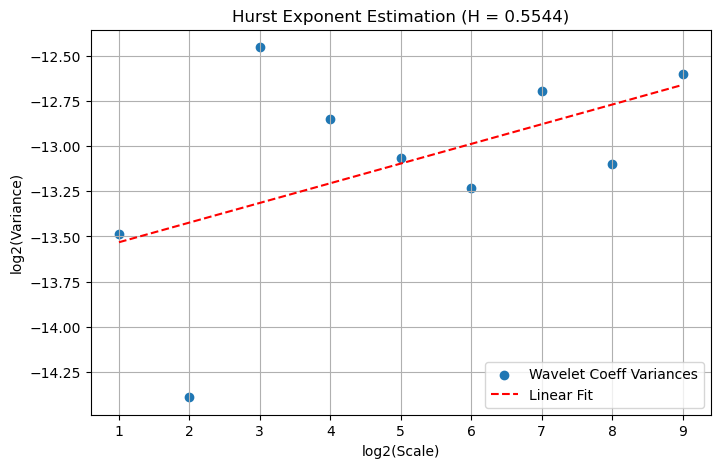

Estimated Hurst Exponent: 0.5544


In [617]:
# Example usage on S&P 500 log returns
SNP_hurst_est = hurst_wavelet(SNP_training_df["log_returns"], wavelet='haar', max_level=9)
print(f"Estimated Hurst Exponent: {SNP_hurst_est:.4f}")

In [618]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series):
    """
    Performs ADF and KPSS tests on a time series.

    Parameters:
        series (pd.Series): The time series data.

    Returns:
        None (Prints test results)
    """
    # Augmented Dickey-Fuller Test (ADF)
    adf_result = adfuller(series, autolag='AIC')
    print("Augmented Dickey-Fuller Test Results:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")
    print("➡ Stationary" if adf_result[1] < 0.05 else "➡ Non-Stationary")

    print("\n" + "="*50 + "\n")

    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags="auto")  # 'c' = constant (level stationarity)
    print("KPSS Test Results:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"   {key}: {value:.4f}")
    print("➡ Non-Stationary" if kpss_result[1] < 0.05 else "➡ Stationary")

# Run the tests on S&P 500 log returns
stationarity_tests(SNP["log_returns"])

Augmented Dickey-Fuller Test Results:
ADF Statistic: -15.7514
p-value: 0.0000
Critical Values:
   1%: -3.4330
   5%: -2.8627
   10%: -2.5674
➡ Stationary


KPSS Test Results:
KPSS Statistic: 0.0495
p-value: 0.1000
Critical Values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
➡ Stationary


/Users/benjaminang/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [619]:
from stochastic.processes.continuous import FractionalBrownianMotion
import numpy as np
import random
import plotly.graph_objects as go

def generate_fbm_price(train_data, test_data, H):
    # Set a fixed seed inside the function for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Calculate drift (μ) and volatility (σ) from training log returns
    mu = train_data["log_returns"].mean()  # Drift set to 0 for now
    sigma = train_data["log_returns"].std()

    # Define Fractional Brownian Motion (fBM) model
    n_days = len(test_data)  # Number of forecast days

    # ✅ Set seed before generating fBM to ensure reproducibility
    fbm = FractionalBrownianMotion(hurst=H, t=n_days-1)
    fbm_values = fbm.sample(n=n_days-1)  # Generate fBM values
  
    # Convert fBM to a stock price forecast
    S0 = train_data['price'][0]  # Last known price
    print(S0)

    # Simulate price paths using geometric fractional Brownian motion
    simulated_prices = S0 * np.exp(mu * np.arange(n_days) + sigma * fbm_values)
    simulated_prices = simulated_prices[::-1]

    # Create a Plotly figure for actual vs. simulated prices
    fig = go.Figure()

    # Actual price trace
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=test_data["price"],
        mode='lines',
        name='Actual Price',
        line=dict(color='blue')
    ))

    # Forecasted price trace using fBM
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=simulated_prices,
        mode='lines',
        name='Forecasted Price (fBM)',
        line=dict(color='red', dash='dash')
    ))

    # Update layout of the plot
    fig.update_layout(
        title=f"Stock Price Forecast using fBM (H={H})",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        template="plotly_white"
    )

    # Display the interactive plot
    fig.show()

generate_fbm_price(SNP_training_df, SNP_testing_df, SNP_hurst_est)

3839.5


### S&P500 VIX Analysis

In [620]:
# Load the CSV file into df
VIX = pd.read_csv(SNP_VIX_file)
VIX.columns = ["vol"]
VIX.index = pd.to_datetime(VIX.index)
VIX.sort_index()
VIX["log_vol_diff"] = np.log(VIX['vol']/ VIX['vol'].shift(1))
VIX = VIX[1:]

VIX.head()

,vol,log_vol_diff
2024-12-30,17.40,0.002878
2024-12-27,15.95,-0.087011
2024-12-26,14.73,-0.079573
2024-12-24,14.27,-0.031727
2024-12-23,16.78,0.162028


In [621]:
vix_training_start, vix_training_end = "2015-01-02", "2022-12-30"
# vix_training_start, vix_training_end = "2020-02-01", "2020-04-30"     # COVID period
vix_testing_start, vix_testing_end = "2023-01-03", "2024-12-31"

vix_training_df = VIX[(VIX.index >= vix_training_start) & (VIX.index <= vix_training_end)]
vix_testing_df = VIX[(VIX.index >= vix_testing_start) & (VIX.index <= vix_testing_end)]
vix_training_df.head()

,vol,log_vol_diff
2022-12-30,21.67,-0.055208
2022-12-29,21.44,-0.010670
2022-12-28,22.14,0.032128
2022-12-27,21.65,-0.022380
2022-12-23,20.87,-0.036693


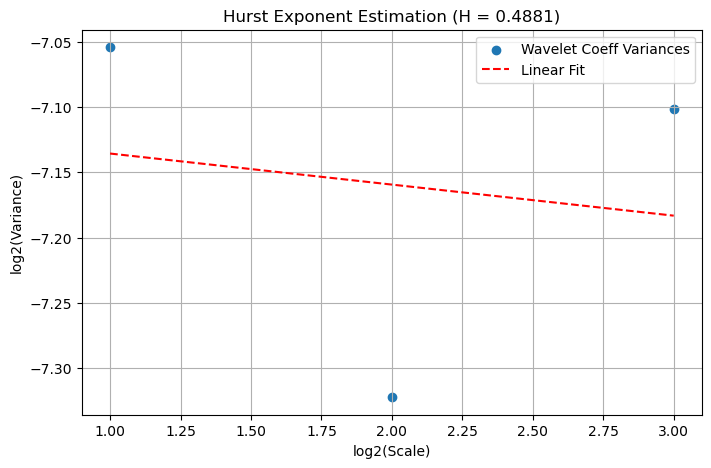

Estimated Hurst Exponent: 0.4881


In [622]:
vix_hurst_est = hurst_wavelet(vix_training_df["log_vol_diff"], wavelet='haar', max_level=3)
print(f"Estimated Hurst Exponent: {vix_hurst_est:.4f}")

In [623]:
def generate_fbm_vol(train_data, test_data, H):
    # Set a fixed seed inside the function for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Calculate drift (μ) and volatility (σ) from training log returns
    mu = train_data["log_vol_diff"].mean()  # Drift set to 0 for now
    sigma = train_data["log_vol_diff"].std()

    # Define Fractional Brownian Motion (fBM) model
    n_days = len(test_data)  # Number of forecast days

    # ✅ Set seed before generating fBM to ensure reproducibility
    fbm = FractionalBrownianMotion(hurst=H, t=n_days-1)
    fbm_values = fbm.sample(n=n_days-1)  # Generate fBM values
  
    # Convert fBM to a stock price forecast
    S0 = train_data['vol'][0]  # Last known price
    print(S0)

    # Simulate price paths using geometric fractional Brownian motion
    simulated_prices = S0 * np.exp(mu * np.arange(n_days) + sigma * fbm_values)
    simulated_prices = simulated_prices[::-1]

    # Create a Plotly figure for actual vs. simulated prices
    fig = go.Figure()

    # Actual price trace
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=test_data["vol"],
        mode='lines',
        name='Actual Vol',
        line=dict(color='blue')
    ))

    # Forecasted price trace using fBM
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=simulated_prices,
        mode='lines',
        name='Forecasted Volatility (fBM)',
        line=dict(color='red', dash='dash')
    ))

    # Update layout of the plot
    fig.update_layout(
        title=f"Volatility Forecast using fBM (H={H})",
        xaxis_title="Date",
        yaxis_title="Volatility",
        template="plotly_white"
    )

    # Display the interactive plot
    fig.show()

generate_fbm_vol(vix_training_df, vix_testing_df, vix_hurst_est)

21.67


In [624]:
# Test using Geometric BM
def simulate_1d_gbm(nsteps=1000, t=1, mu=0.0001, sigma=0.02, start=1):
    steps = [ (mu - (sigma**2)/2) + np.random.randn()*sigma for i in range(nsteps) ]
    y = start*np.exp(np.cumsum(steps))
    x = [ t*i for i in range(nsteps) ]
    return x, y

nsteps = vix_testing_df.shape[0]
mu = np.mean(vix_training_df['log_vol_diff'])
sigma = np.std(vix_training_df['log_vol_diff'])
last_price = vix_training_df['vol'][0]
print(last_price)

x, y = simulate_1d_gbm(nsteps=nsteps, mu=mu, sigma=sigma, start=last_price)

data = {}
data['x'] = x
data['Simulation'] = y
data['log_vol_diff'] = vix_testing_df['vol']


fig = px.line(data,x='x', y=['log_vol_diff', 'Simulation'])
fig.show()

21.67
